<a href="https://colab.research.google.com/github/TheOctoMizer/AAI-511-Project/blob/main/Koelgeet_Kaur_511.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classical Composer Classification**

**Author:** Koelgeet Kaur  
**Date:** August 11, 2025  
**Course:** AAI-511


### **Project Goal**
The objective of this project is to develop and train a deep learning model capable of accurately identifying a composer (Bach, Beethoven, Chopin, or Mozart) from a given musical MIDI file.

# 0. SETUP AND IMPORTS

This cell handles the initial setup of the programming environment. It installs the `music21` library for parsing MIDI files and imports all necessary libraries for the project.

* **Data Handling:** `numpy`, `pandas`
* **Music Processing:** `music21`
* **Data Visualization:** `matplotlib`, `seaborn`
* **Machine Learning:** `sklearn` for data splitting and metrics.
* **Deep Learning:** `tensorflow.keras` for building and training the neural network.
* **Utilities:** `os`, `pathlib`, `multiprocessing`, `tqdm` for file handling and performance optimization.



In [ ]:

# Install required libraries

!pip install -q music21

# Import Libraries
import numpy as np
import pandas as pd
from music21 import converter, note, chord
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from multiprocessing import Pool, cpu_count
from collections import Counter
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

print("\nAll libraries imported successfully.")



All libraries imported successfully.


# 1. DATA LOADING AND PREPROCESSING

### 1.1. Mount Google Drive
This cell mounts Google Drive, allowing the Colab notebook to access the MIDI dataset files stored there.




In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")


Mounted at /content/drive
Google Drive mounted successfully.


### 1.2. Define Project Constants
Here, we define the main variables for the project. `data_dir` points to the location of our MIDI dataset, and `COMPOSERS` is a list that defines our target classes.
### 1.3. Scan Dataset and Create DataFrame
This code scans the dataset directory, walking through each composer's subfolder to find all `.mid` files. It then organizes the file paths and their corresponding composer labels into a pandas DataFrame, giving us a structured view of the entire dataset.



In [ ]:

# Define Composers and Paths
data_dir = Path('/content/drive/MyDrive/Final_MIDI_dataset')
COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Scan all files to create a master DataFrame
filepaths = []
labels = []
for composer in COMPOSERS:
    composer_path = data_dir / composer
    if composer_path.is_dir():
        for file in composer_path.glob('**/*.mid'):
            filepaths.append(str(file))
            labels.append(composer)

music_df = pd.DataFrame({'filepath': filepaths, 'composer': labels})
print(f"Found a total of {len(music_df)} MIDI files.")
print("\nOriginal dataset distribution:")
print(music_df['composer'].value_counts())


Found a total of 1530 MIDI files.

Original dataset distribution:
composer
Bach         925
Mozart       257
Beethoven    212
Chopin       136
Name: count, dtype: int64


### 1.4. Visualize the Data Imbalance
This cell creates a bar chart to visualize the core challenge of this project. The plot clearly shows the number of files for each composer, highlighting the severe class imbalance that must be addressed before training a model.


/tmp/ipython-input-3632308559.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='composer', data=music_df, order=music_df['composer'].value_counts().index, palette='viridis')


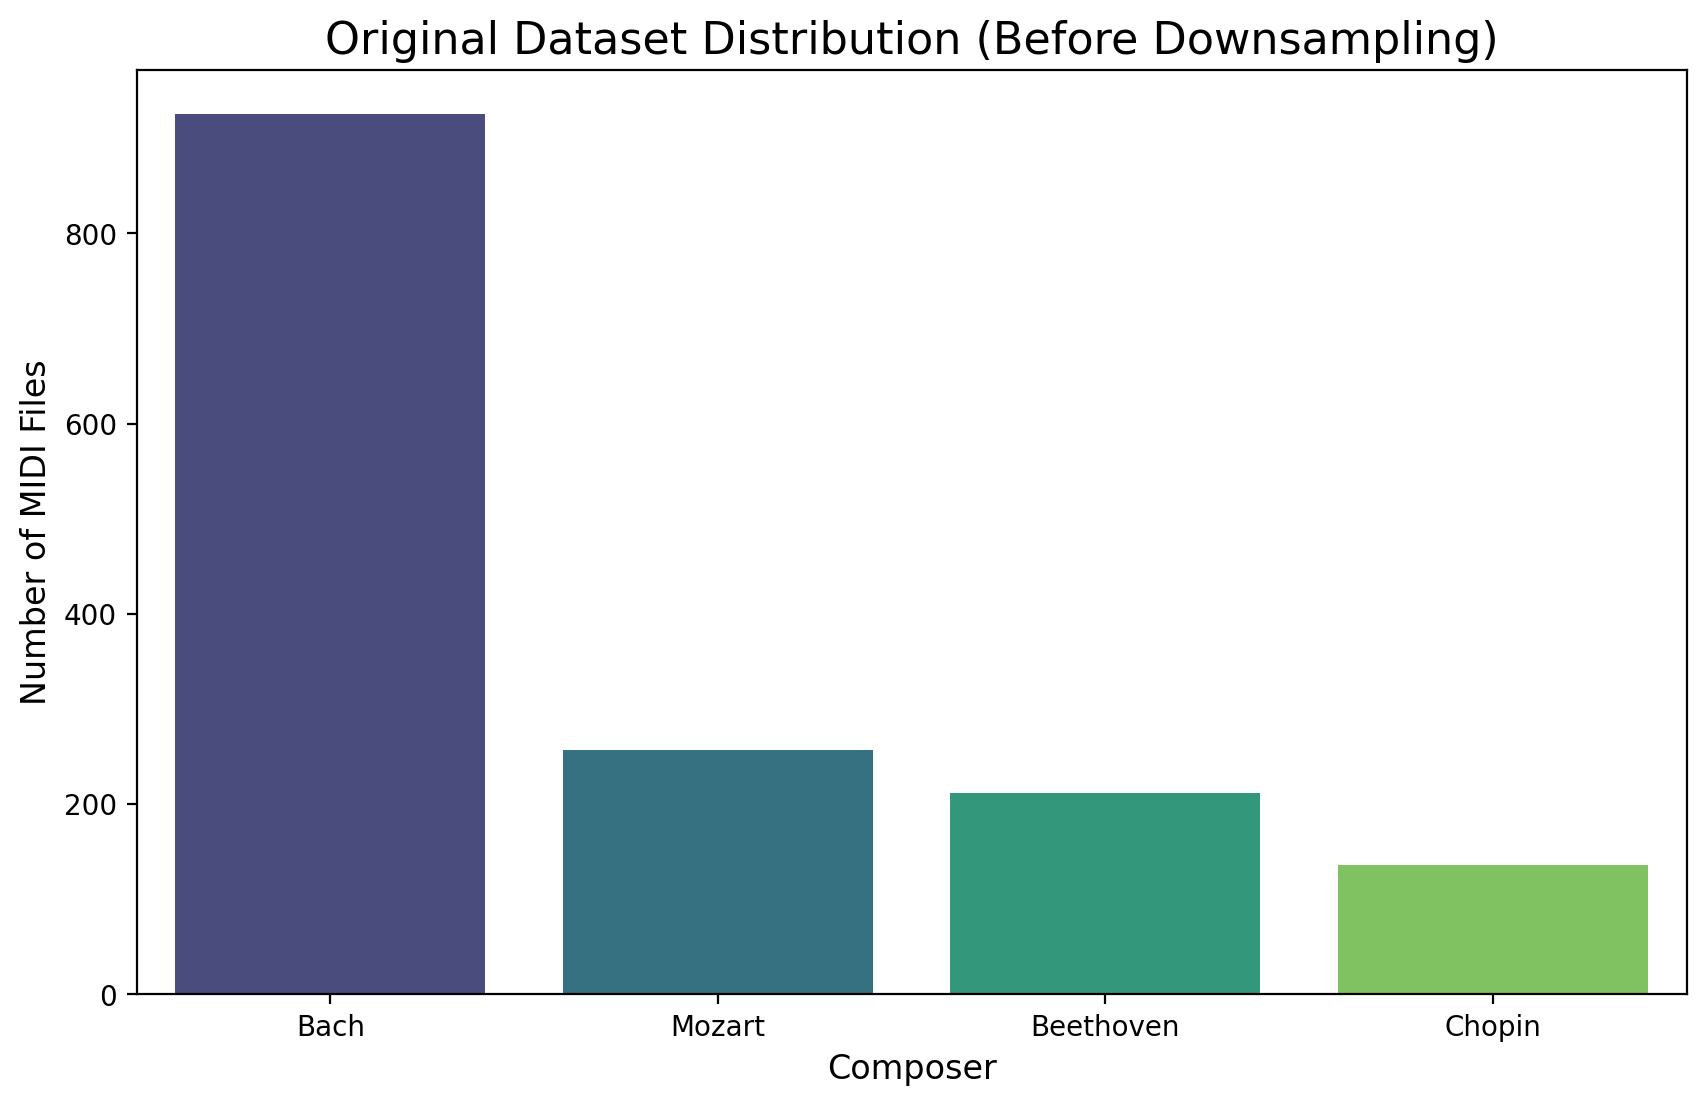

In [ ]:

# Visualize the original imbalanced data distribution.
plt.figure(figsize=(10, 6))
sns.countplot(x='composer', data=music_df, order=music_df['composer'].value_counts().index, palette='viridis')
plt.title('Original Dataset Distribution (Before Downsampling)', fontsize=16)
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Number of MIDI Files', fontsize=12)
plt.show()


### 1.5. Downsample the Dataset
Here, we perform the crucial data balancing step. The code identifies the composer with the fewest files (the minority class) and then randomly samples that same number of files from all other composers. This creates a new, perfectly balanced DataFrame, which is essential for preventing model bias.


In [ ]:


# Downsample the dataset to the size of the smallest class.
min_count = music_df['composer'].value_counts().min()
print(f"\nDownsampling to {min_count} files per composer.")

balanced_dfs = [music_df[music_df['composer'] == c].sample(min_count, random_state=42) for c in COMPOSERS]
balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced dataset created. New distribution:")
print(balanced_df['composer'].value_counts())
print(f"Total files in balanced dataset: {len(balanced_df)}")



Downsampling to 136 files per composer.

Balanced dataset created. New distribution:
composer
Mozart       136
Beethoven    136
Chopin       136
Bach         136
Name: count, dtype: int64
Total files in balanced dataset: 544


### 1.6. Confirm the Balanced Distribution
This second bar chart serves as a confirmation of our downsampling strategy. It visualizes the new distribution, showing that each composer now has an equal number of files in the dataset we will use for training.


/tmp/ipython-input-1451210761.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='composer', data=balanced_df, order=COMPOSERS, palette='magma')


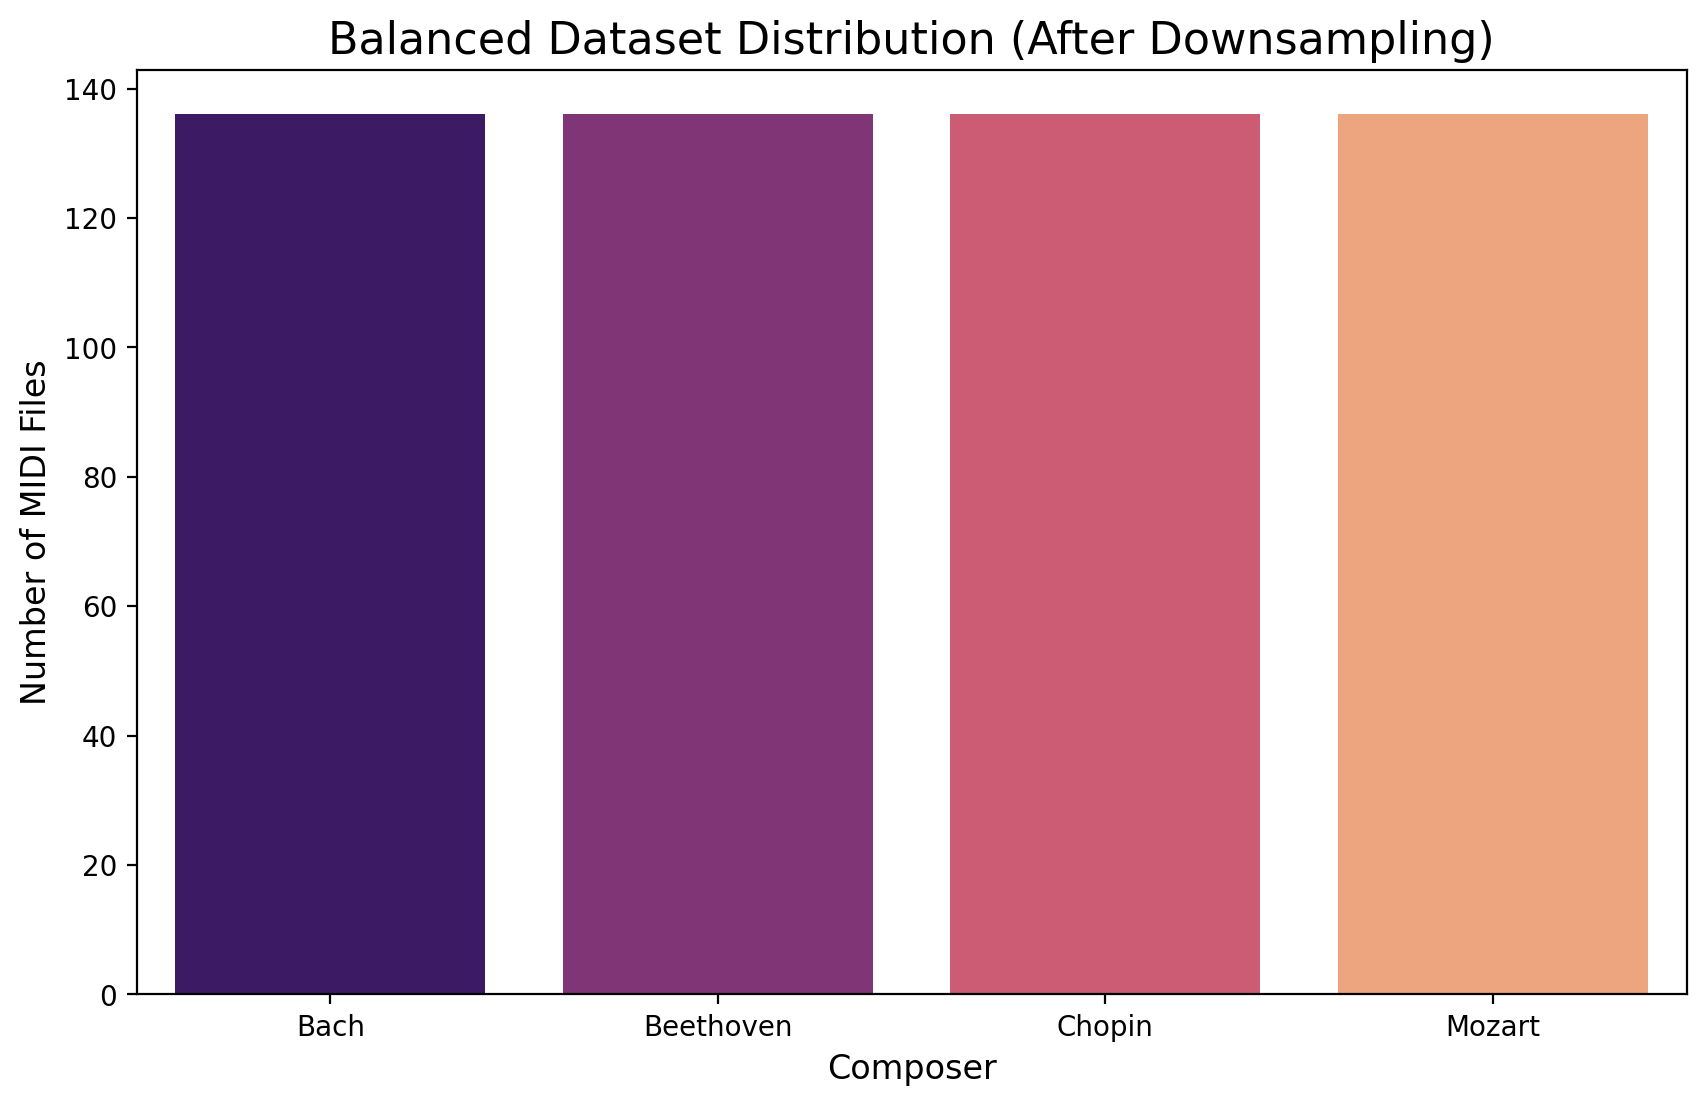

In [ ]:


# Visualize the new balanced data distribution.
plt.figure(figsize=(10, 6))
sns.countplot(x='composer', data=balanced_df, order=COMPOSERS, palette='magma')
plt.title('Balanced Dataset Distribution (After Downsampling)', fontsize=16)
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Number of MIDI Files', fontsize=12)
plt.show()


# 2. FEATURE EXTRACTION & SEQUENCE GENERATION

### 2.1. Define the MIDI Parsing Function
This cell defines the core feature extraction function, `get_notes_from_midi`. This function takes a single MIDI file path, uses the `music21` library to parse the musical score, and extracts a list of all the notes and chords, representing them as simple strings (e.g., "C#4", "4.7.11").


In [ ]:


# Define the parsing function
def get_notes_from_midi(file_path):
    """Parses a single MIDI file and returns a list of note/chord strings."""
    notes = []
    try:
        midi = converter.parse(file_path)
        notes_to_parse = midi.flatten().notes
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    except Exception as e:
        return None
    return notes


### 2.2. Parse MIDI Files in Parallel
This is the most time-consuming step of the data preparation. To significantly speed it up, this cell uses Python's `multiprocessing` library to parse multiple MIDI files at the same time, utilizing all available CPU cores. A progress bar (`tqdm`) is used to monitor the process.


In [ ]:

# Use multiprocessing to parse MIDI files in parallel.

import warnings
# Suppress music21 warnings during the parallel parsing step
warnings.filterwarnings("ignore")

filepaths_to_parse = balanced_df['filepath'].tolist()
print(f"\nStarting parallel parsing of {len(filepaths_to_parse)} files on {cpu_count()} CPU cores...")

with Pool(processes=cpu_count()) as pool:
    parsed_results = list(tqdm(pool.imap(get_notes_from_midi, filepaths_to_parse), total=len(filepaths_to_parse)))

balanced_df['parsed_notes'] = parsed_results
print("\nParallel parsing complete.")



Starting parallel parsing of 544 files on 12 CPU cores...


100%|██████████| 544/544 [09:33<00:00,  1.05s/it]


Parallel parsing complete.


### 2.3. Exploratory Data Analysis (EDA) on Composition Length
This cell performs some initial exploratory data analysis on our balanced dataset. It creates a violin plot to visualize the distribution of composition lengths (total number of notes/chords) for each composer. This can reveal interesting stylistic differences.


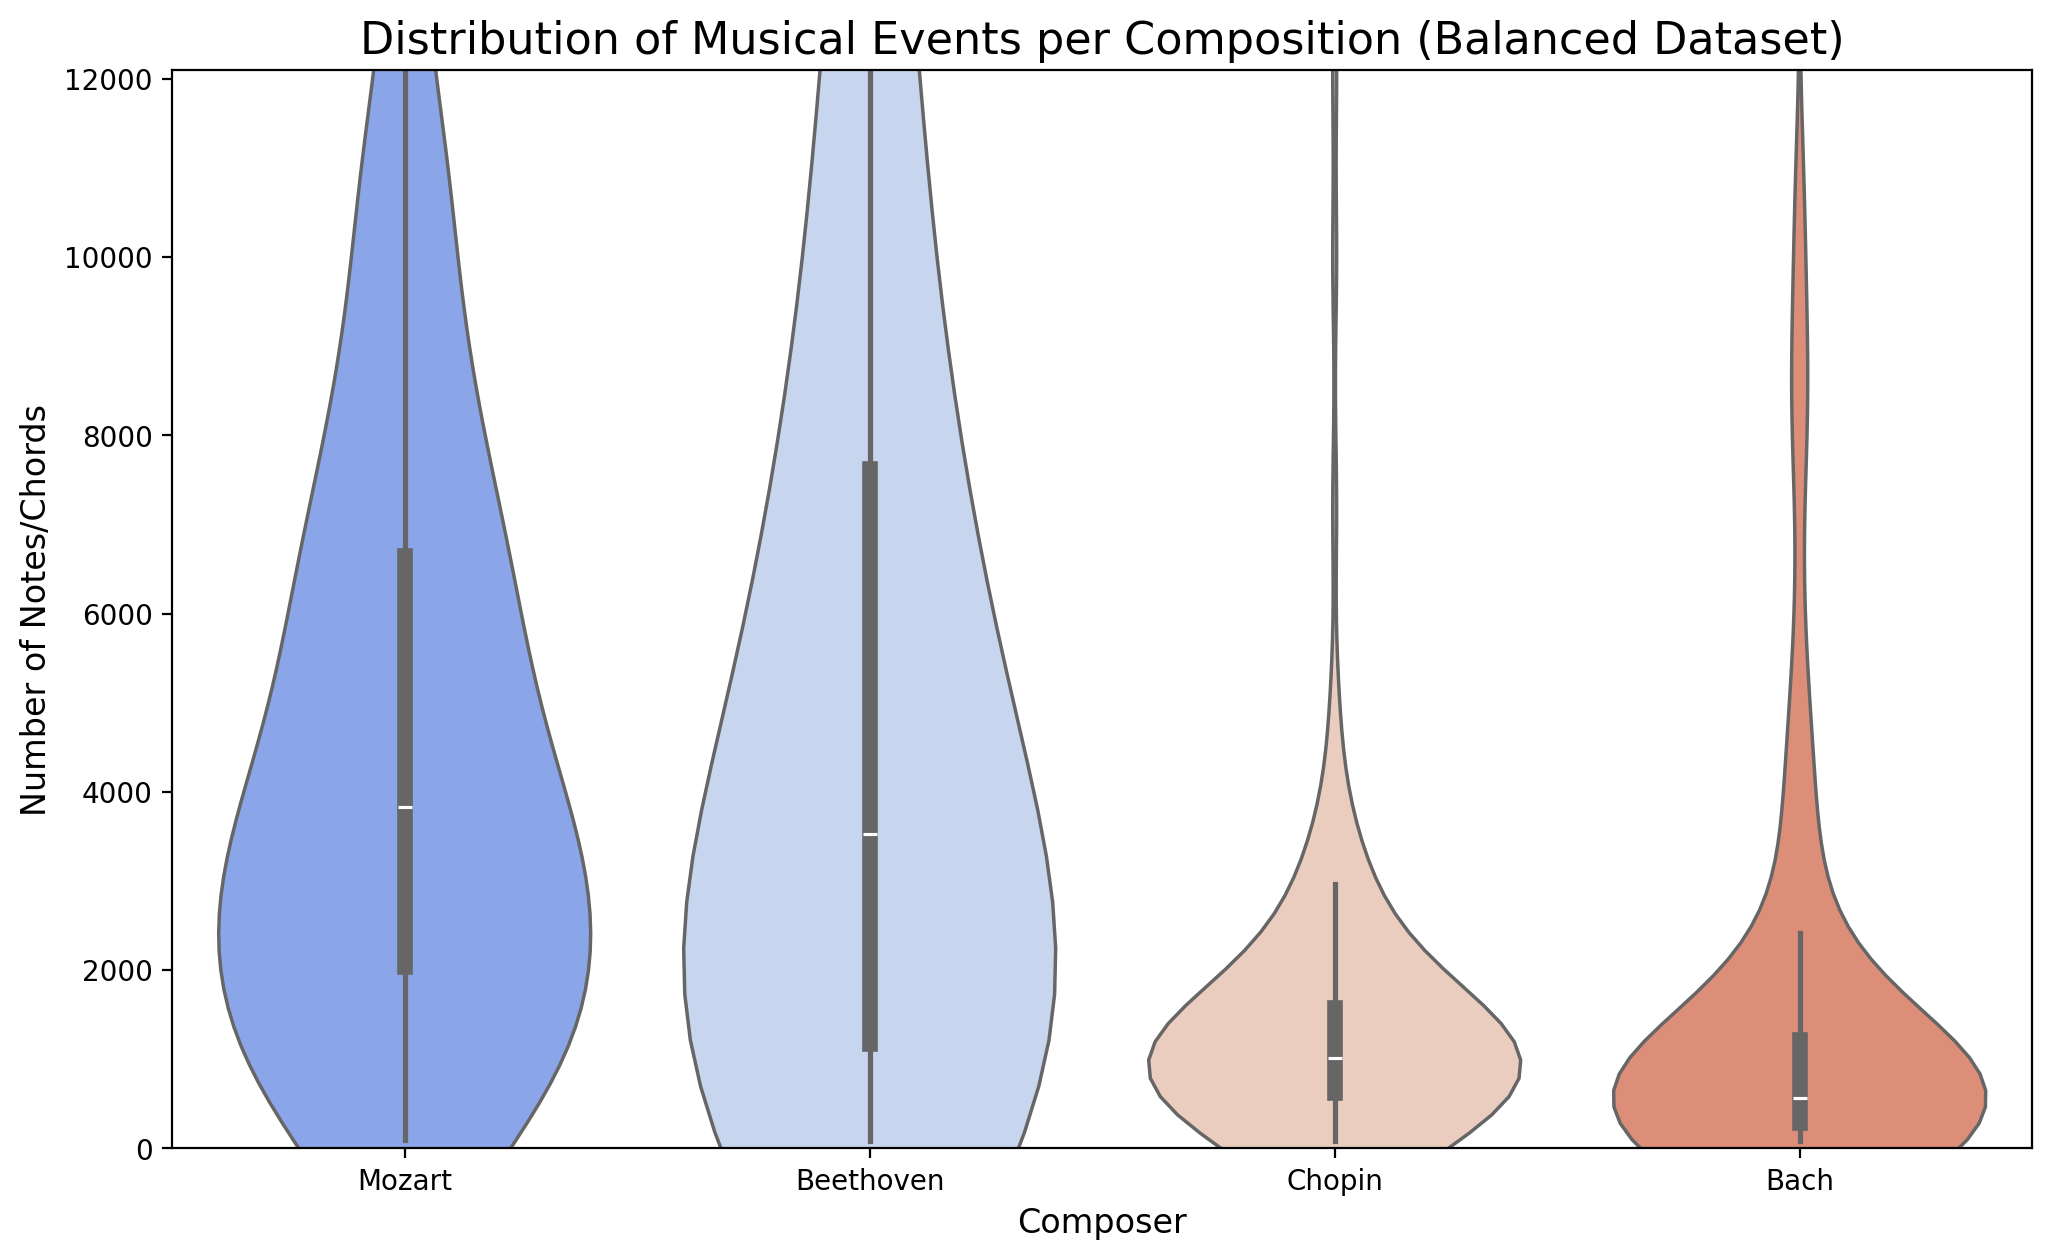

In [ ]:


# EDA on composition length
balanced_df['num_events'] = balanced_df['parsed_notes'].apply(lambda x: len(x) if x is not None else 0)
plt.figure(figsize=(12, 7))
sns.violinplot(x='composer', y='num_events', data=balanced_df, palette='coolwarm')
plt.title('Distribution of Musical Events per Composition (Balanced Dataset)', fontsize=16)
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Number of Notes/Chords', fontsize=12)
plt.ylim(0, balanced_df['num_events'].quantile(0.95)) # Cap y-axis to see distribution clearly
plt.show()

From the plot

### 2.4. Generate Musical Sequences
Here, we create the actual training examples for our model. The code takes the long list of notes from each parsed file and chops it into many small, overlapping sequences of a fixed length (30 notes). This process generates a very large dataset of musical snippets, which is ideal for training a deep learning model.


In [ ]:
# Now, generate sequences from the parsed notes
all_sequences = []
all_labels = []
composer_to_id = {composer: i for i, composer in enumerate(COMPOSERS)}

SEQUENCE_LENGTH = 30 # small sequence length to make the task harder.

STEP_SIZE = 5

print(f"Generating sequences of length {SEQUENCE_LENGTH} with a step of {STEP_SIZE}...")
for index, row in balanced_df.iterrows():
    composer_id = composer_to_id[row['composer']]
    notes_for_file = row['parsed_notes']

    if notes_for_file and len(notes_for_file) > SEQUENCE_LENGTH:
        for i in range(0, len(notes_for_file) - SEQUENCE_LENGTH, STEP_SIZE):
            sequence = notes_for_file[i: i + SEQUENCE_LENGTH]
            all_sequences.append(sequence)
            all_labels.append(composer_id)

print(f"\nCreated {len(all_sequences)} sequences from the balanced dataset.")


Generating sequences of length 30 with a step of 5...

Created 367336 sequences from the balanced dataset.


### 2.5. Build the Vocabulary
This cell builds the model's dictionary, or "vocabulary." It finds every unique note and chord across all the generated sequences and creates a map that assigns a unique integer to each one. To reduce noise, it filters out very rare musical events that appear fewer than 10 times.


In [ ]:
# Create vocabulary
all_notes = [n for seq in all_sequences for n in seq]
vocab_counts = Counter(all_notes)
# Increased filter count to make vocabulary smaller and task harder.
filtered_notes = {n: count for n, count in vocab_counts.items() if count >= 10}
vocab_size = len(filtered_notes) + 1
note_to_int = {n: i+1 for i, n in enumerate(filtered_notes)}
note_to_int['UNK'] = 0

print(f"Vocabulary size (filtered): {vocab_size}")


Vocabulary size (filtered): 865


### 2.6. Encode Sequences
This cell prepares the data for the neural network. It uses the vocabulary map from the previous step to convert each sequence of note strings into a corresponding sequence of integers.


In [ ]:
# Convert sequences to integers
encoded_sequences = []
for seq in all_sequences:
    temp_seq = [note_to_int.get(n, 0) for n in seq]
    encoded_sequences.append(temp_seq)


### 2.7. Finalize and Split the Dataset
Here, we finalize the data preparation. The Python lists are converted into efficient NumPy arrays, and the full dataset is split into a training set (80% of the data) and a test set (20%) that will be used for the final evaluation.


In [ ]:
# Prepare final data
X = np.array(encoded_sequences)
y = np.array(all_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nFinal training sequences: {len(X_train)}")
print(f"Final testing sequences: {len(X_test)}")


Final training sequences: 293868
Final testing sequences: 73468


# 3. MODEL ARCHITECTURE & TRAINING

### 3.1. Define the Model Architecture
This cell defines the structure of our deep learning model using the Keras Sequential API. It is a hybrid model designed to understand musical data:
* An **Embedding** layer learns the relationships between different notes.
* A **Conv1D** layer finds local patterns and musical motifs.
* An **LSTM** layer understands the sequence and order of those patterns.
* **Dropout** and **BatchNormalization** layers are used throughout to prevent overfitting and stabilize training.
* **Dense** layers at the end perform the final classification.

### 3.2. Compile and Build the Model
This cell gets the model ready for training.
* `.compile()` configures the model with an optimizer (Adam), a loss function for multi-class classification, and the metric we want to track (accuracy).
* `.build()` pre-allocates the model's weights based on the expected input shape. This is a necessary step before we can visualize the architecture.
* `.summary()` prints a text-based table of the model's layers and parameter counts.


In [ ]:


# Using a simpler architecture that will be challenged by the shorter sequences.
final_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=SEQUENCE_LENGTH),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(units=128),
    BatchNormalization(),
    Dropout(0.4),

    Dense(units=128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(COMPOSERS), activation='softmax')
])

final_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.build(input_shape=(None, SEQUENCE_LENGTH))

final_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 128)        │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 26, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,916 (1.31 MB)

 Trainable params: 342,148 (1.31 MB)

 Non-trainable params: 768 (3.00 KB)

### 3.3. Visualize the Architecture
This cell uses the `plot_model` utility to generate a clear, visual diagram of our model's architecture. This graph shows each layer, its input and output shapes, and how the layers connect to one another.



Model Architecture:


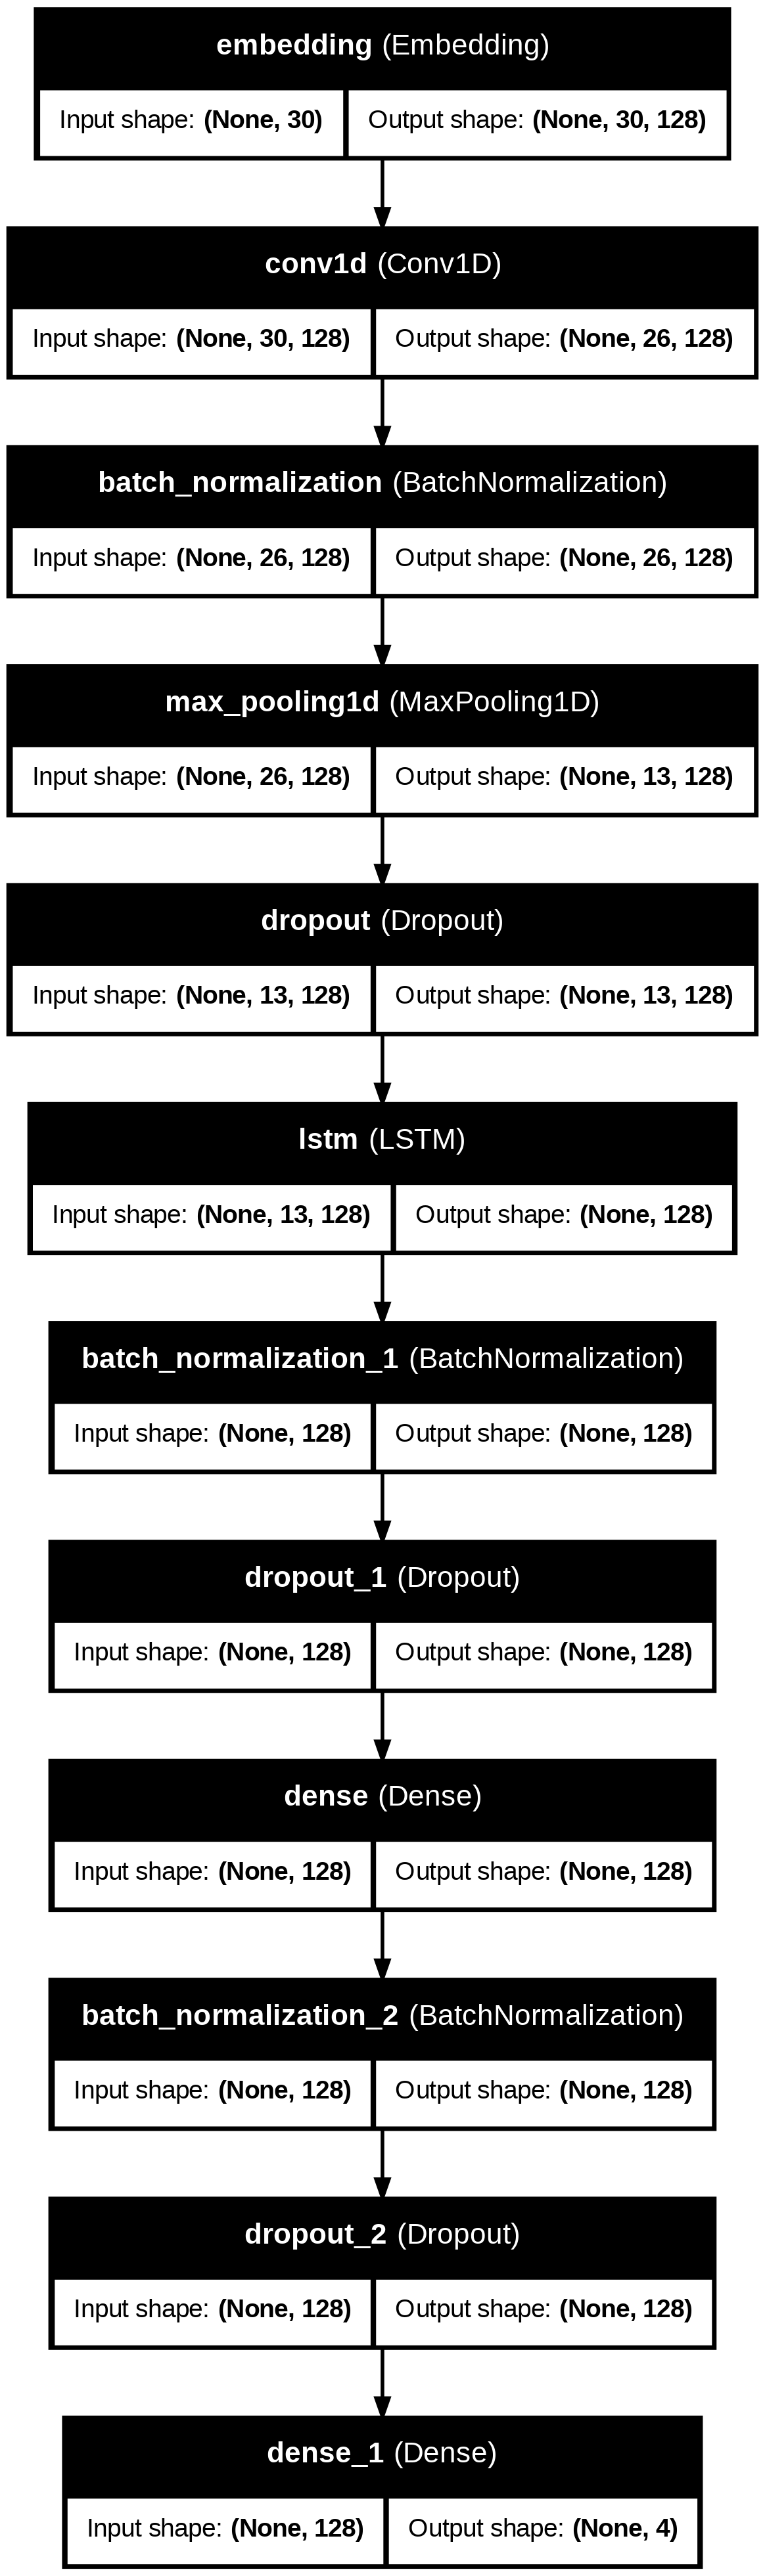

In [ ]:
# Visualize the model architecture
print("\nModel Architecture:")
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
display(Image(filename='model_plot.png'))

### 3.4. Train the Model
This is the main training step. The `model.fit()` function trains the neural network on our prepared training data. It uses an `EarlyStopping` callback, which monitors the performance on a validation set (a small portion of the training data) and will automatically stop the training process when the model is no longer improving, ensuring we get the best version of the model without overfitting.


In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

history = final_model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)

print("\nModel training complete.")


Epoch 1/150
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.5148 - loss: 1.1598 - val_accuracy: 0.7172 - val_loss: 0.6753
Epoch 2/150
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7199 - loss: 0.6798 - val_accuracy: 0.7731 - val_loss: 0.5597
Epoch 3/150
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7751 - loss: 0.5613 - val_accuracy: 0.8081 - val_loss: 0.4846
Epoch 4/150
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8020 - loss: 0.4989 - val_accuracy: 0.8268 - val_loss: 0.4475
Epoch 5/150
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8227 - loss: 0.4526 - val_accuracy: 0.8493 - val_loss: 0.3936
Epoch 6/150
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8381 - loss: 0.4164 - val_accuracy: 0.8591 - val_loss: 0.3623
Epoch 7/150
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8480 - loss: 0.3950 - val_accuracy: 0.8687 - val_loss: 0.3471
Epoch 8/150
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8576 -

# 4. EVALUATION & RESULTS

### 4.1. Visualize Training and Validation Performance
This cell plots the results of the training process. It creates two graphs: one for accuracy and one for loss. By comparing the training curves (blue) to the validation curves (orange), we can confirm that the model learned effectively and generalized well, as indicated by the fact that the two curves track each other closely.


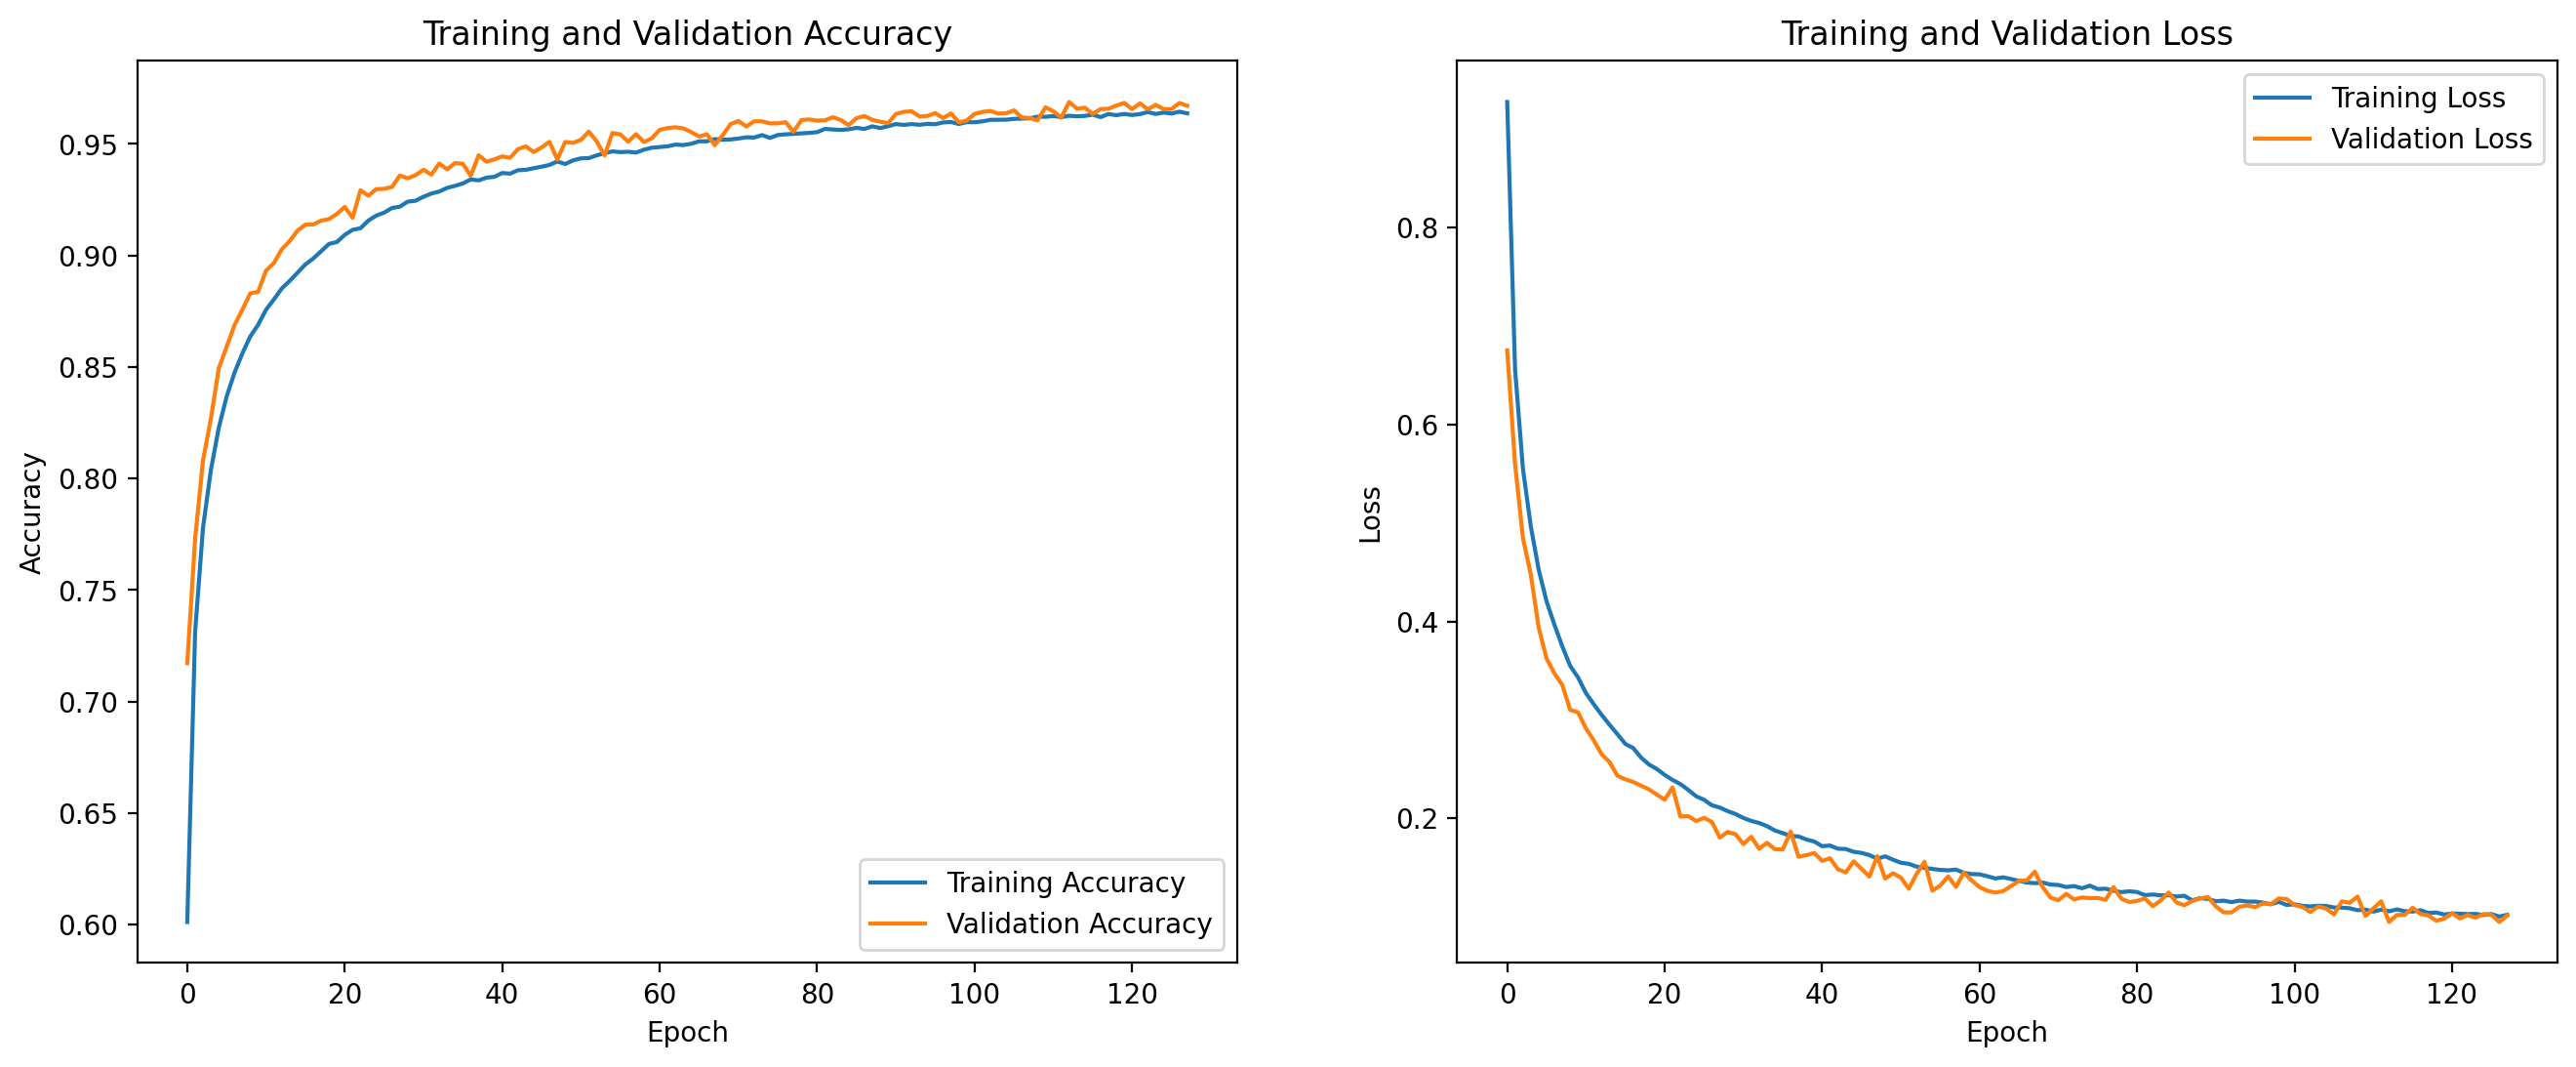

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### 4.2. Evaluate Final Performance on the Test Set
Here, we evaluate the final performance of our trained model on the unseen test data. The model makes predictions, and the code outputs:
1.  The final **Test Accuracy** and **Test Loss**.
2.  A detailed **Classification Report** with metrics like precision, recall, and F1-score for each composer.


In [ ]:
print("\n--- Evaluating the Final Model on the Test Set ---")
loss, accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=COMPOSERS))



--- Evaluating the Final Model on the Test Set ---

Test Accuracy: 96.79%
Test Loss: 0.0945
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Classification Report:
              precision    recall  f1-score   support

        Bach       0.95      0.97      0.96      8056
   Beethoven       0.97      0.97      0.97     31583
      Chopin       0.97      0.97      0.97      8184
      Mozart       0.97      0.96      0.97     25645

    accuracy                           0.97     73468
   macro avg       0.97      0.97      0.97     73468
weighted avg       0.97      0.97      0.97     73468



### 4.3. Visualize the Standard and Normalized Confusion Matrix

This cell creates a Confusion Matrix showing the raw counts of correct and incorrect predictions. It also creates a second, more intuitive confusion matrix. Instead of showing raw counts, this "normalized" matrix shows the results as percentages. This makes it easier to interpret the model's performance for each composer, regardless of the number of test samples in each class.


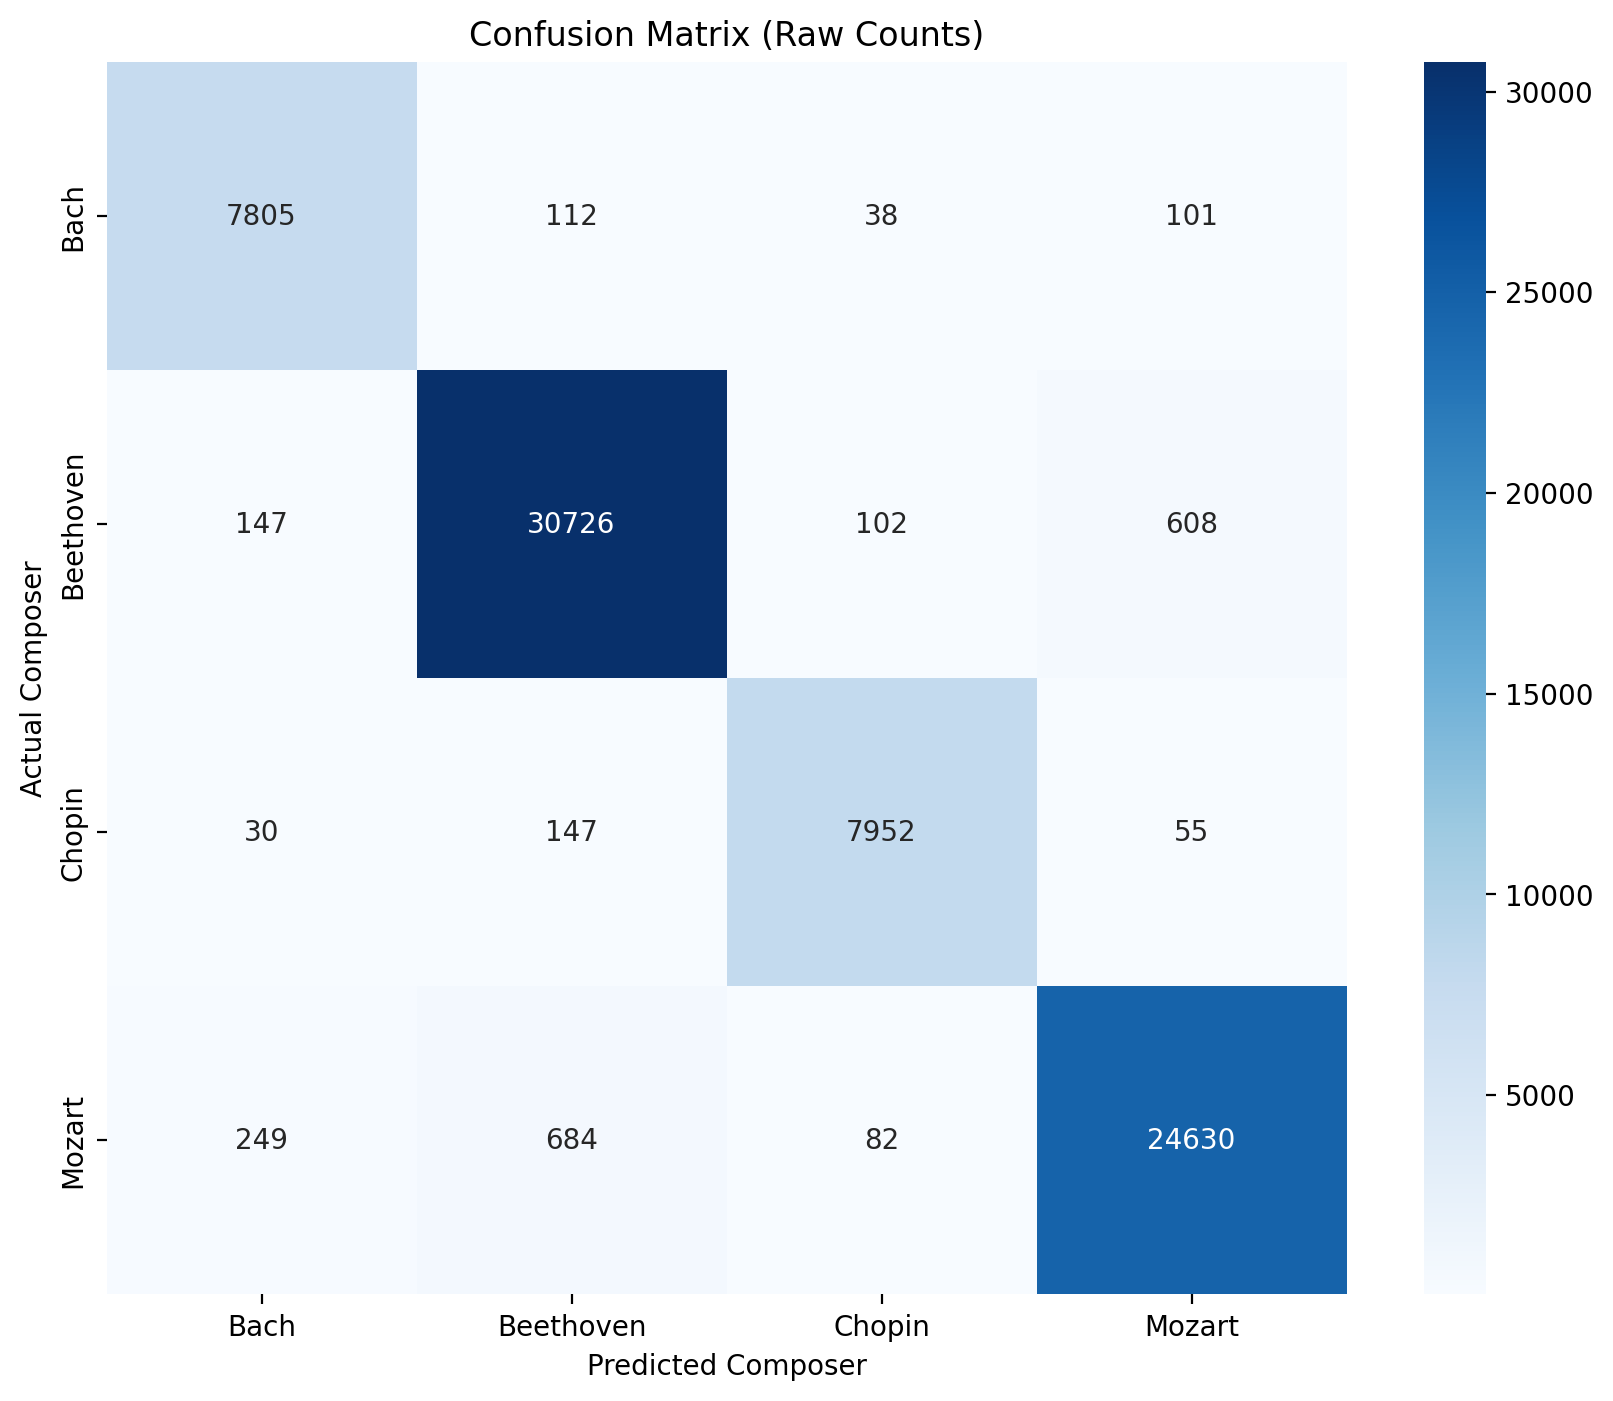

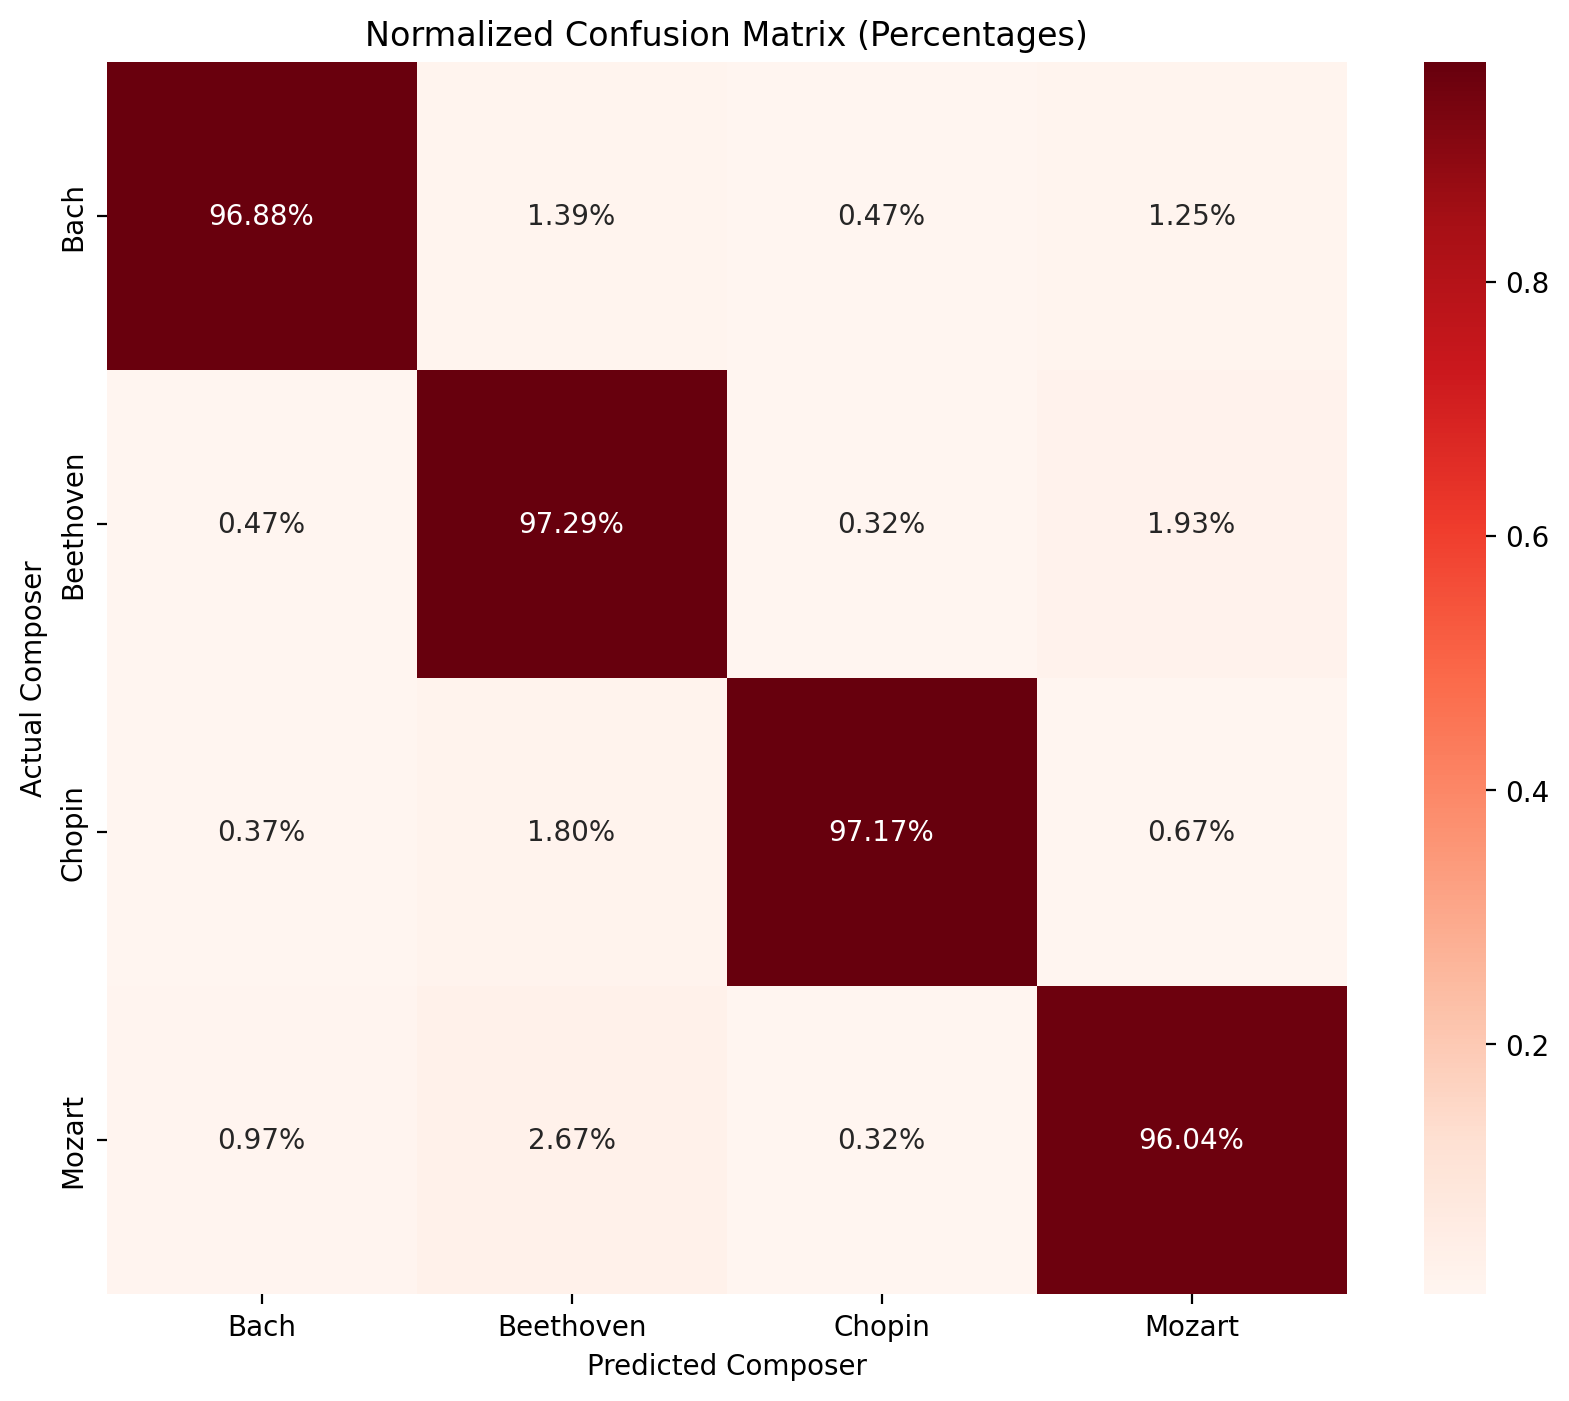

In [ ]:
# Standard Confusion Matrix (Raw Counts)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=COMPOSERS, yticklabels=COMPOSERS)
plt.title('Confusion Matrix (Raw Counts)')
plt.ylabel('Actual Composer')
plt.xlabel('Predicted Composer')
plt.show()

# Normalized Confusion Matrix (Percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Reds', xticklabels=COMPOSERS, yticklabels=COMPOSERS)
plt.title('Normalized Confusion Matrix (Percentages)')
plt.ylabel('Actual Composer')
plt.xlabel('Predicted Composer')
plt.show()
